## Watershed mapping

This notebook is used to generate a map of the watershed for a specific gauge.  Remember that a *watershed* is area that drains to a certain point.  

For our gauges, the watershed will include all of the rivers that are upstream of the gauge. 

Enter your gauge station ID below to get started!


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd

import pygeohydro as gh
from pygeohydro import NWIS

from pynhd import NLDI

In [19]:
station_id = "04234000"
distance=1000

<Axes: >

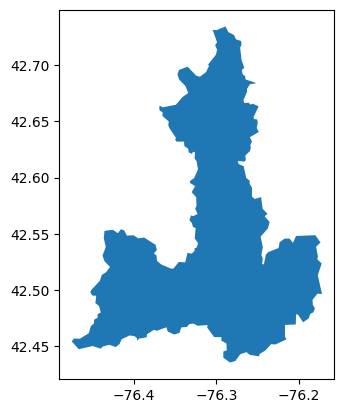

In [28]:
# Lets get the streamflow data, which may be good to add below the map
flow = NWIS().get_streamflow(station_id, dates = ('1900-01-01', '2022-12-31'))
flow.index = pd.to_datetime(flow.index)

## Now we need to get the geospatial data
nldi = NLDI()

# Get the watershed boundary
watershed_boundary = nldi.get_basins(station_id)

# Plot the watershed boundary to make sure it worked
watershed_boundary.plot()

Great, we've got the watershed boundary, now we also want to get the actual stream lines inside the basin.  

The `pynhd` library let's us do this using the `navigate_byid` function.  We will do this for the main stream and the tributaries separately. 


In [20]:
# Get the main rivers
main_rivers = nldi.navigate_byid(fsource='nwissite', 
                                 fid=f'USGS-{station_id}', 
                                 source='flowlines', 
                                 distance=distance,
                                 navigation='upstreamMain')

# Get the tributaries
tributary_rivers = nldi.navigate_byid(fsource='nwissite', 
                                      fid=f'USGS-{station_id}',
                                      source='flowlines',
                                      distance=distance, 
                                      navigation='upstreamTributaries')

Let's add all the stream lines to a plot with the watershed boundary!

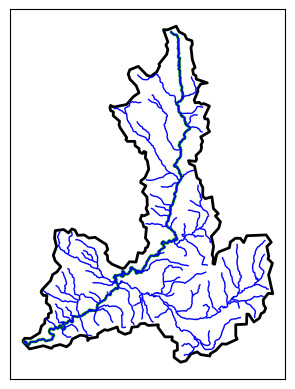

In [43]:
# Start the figure
fig, ax = plt.subplots()

# Add the watershed boundary (set ax=ax to add to the existing figure)
watershed_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# Add main river line in green
main_rivers.plot(ax=ax, color='green', linewidth=2)

# Add tributaries in blue
tributary_rivers.plot(ax=ax, color='blue', linewidth=1)


# Other aesthetics changes and showing the plot
# plt.axis('off')
plt.xticks([])
plt.yticks([])

# Save the figure as an SVG
plt.savefig(f'./Figures/watershed_{station_id}.svg')
plt.show()

Great, we have our map looking nice now.  I want to make a few more changes that will make the figure more fancy....

How about we add all of the streamflow data below the map?



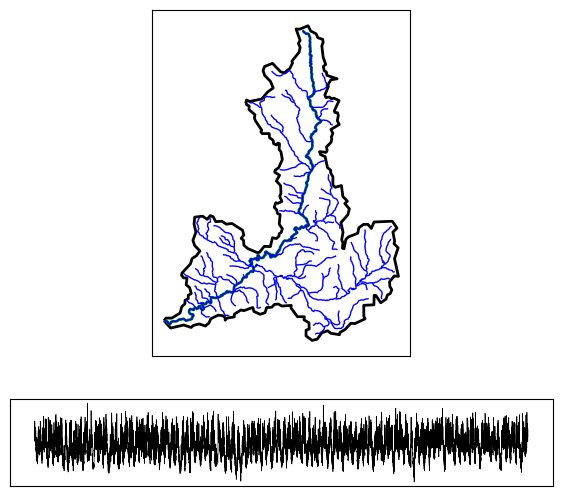

In [42]:
# Start the figure with two axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(7,7), 
                               height_ratios=[4,1],
                               width_ratios=[1])

# Add the watershed boundary (set ax=ax to add to the existing figure)
watershed_boundary.plot(ax=ax1, color='none', edgecolor='black', linewidth=2)

# Add main river line in green
main_rivers.plot(ax=ax1, color='green', linewidth=2)

# Add tributaries in blue
tributary_rivers.plot(ax=ax1, color='blue', linewidth=1)

# Remove axis ticks
ax1.set_xticks([])
ax1.set_yticks([])

### Bottom plot
# Add streamflow data one year at a time
start_year = flow.index.year[0]
end_year = flow.index.year[-1]
for yr in range(start_year, end_year):
    year_flow = flow.loc[flow.index.year == yr]
    year_flow.plot(ax=ax2, color='black', linewidth = 0.5)

# Other aesthetics changes and showing the plot
# Remove the legend and ticks
ax2.get_legend().remove()
ax2.set_yscale('log')
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()